<a href="https://colab.research.google.com/github/RafaelBNN/if697/blob/main/Projeto_2_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A ideia vai ser prever o `Place` de um atleta de acordo com `Age`, `BodyweightKg`, `Sex`, `Division`, `IPFPoints` e `Place` de atletas com atributos semelhantes. O professor sugeriu coletar uma amostra dos últimos 5 anos do dataset original e usar 3,5 anos como *training* set, 0,5 anos como *validation* set e o último ano como *test* set.



*Atualização 27/07*: Acho que esse problema se aplica mais como um problema de regressão, já que não precisamos prever com 100% de certeza a colocação de um competidor. A parte decimal das predições vai nos dar uma ideia da "certeza" do algoritmo de que o competidor vai ficar naquela colocação.

*Atualização 02/08 (acompanhamento)*: Segundo o professor, se formos fazer regressão, deveremos aplicá-la a vários atletas (que talvez tenham participado da mesma competição, não entendi essa parte direito) e rankeá-los de acordo com as previsões, em vez de deixar um número não-inteiro na coluna. Nesse caso, haverá a necessidade de buscarmos registros da mesma competição (na sample que pegamos, temos 1800 registros de 2019; esses registros podem ser, por exemplo de 1800 competições diferentes, e isso talvez não se encaixe na forma com que o professor pensou na solução).

Se fizermos classificação, porém, não parece que teremos esse problema, de modo que o professor não citou "rankear" atletas de acordo com o resultado do modelo (já que não há como rankear classes).

Dado, então, esse problema de ter que buscar registros das mesmas competições para realizar a previsão, parece melhor fazer com classificação, embora o de regressão seja mais fofinho, e acho que faz mais sentido também.

*Atualização 12/08*: Vamos de classificação mesmo. Com regressão pode ser que houvesse alguma dificuldade na hora de avaliar o desempenho do modelo. O treinamento também não seria tão simples, visto que eu teria que separar as competições.

In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
df=pd.read_csv("https://raw.githubusercontent.com/RafaelBNN/datasets/main/powerlifting_final2.csv")

df.head()

,Unnamed: 0,Unnamed: 0.1,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
0,0,674206,Dane Roach,1,SBD,Raw,25.500000,24-34,MR-O,81.20,83,157.5,167.5,175.0,175.00,117.5,122.5,127.5,127.50,205.0,220.0,227.5,227.5,530.0,3,358.49,358.49,346.20,525.08,Yes,NaN,USAPL,2017-12-02,USA,MI,Michigan State Meet,-0.340206,-0.409639,0.051948,-0.148760,-0.344148,-0.167948,"(487.5, 551.11]",1
1,1,507347,Cody Robert,1,SBD,Single-ply,23.744319,NaN,Boys,141.52,124.7+,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.7,523.9,7,292.29,292.29,276.78,345.78,Yes,NaN,THSPA,2019-02-16,USA,TX,Rice Consolidated Booster Club Meet,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
2,2,1054061,Satu Luoto,0,SBD,Raw,46.500000,45-49,Masters 1,62.76,63,122.5,127.5,-132.5,127.50,82.5,85.0,-87.5,85.00,125.0,130.0,-132.5,130.0,342.5,4,368.90,393.98,325.76,593.66,Yes,Finland,IPF,2016-06-19,USA,TX,World Classic Powerlifting Championships,-0.536082,-0.614458,-0.454545,-0.458678,-0.547647,-0.045339,"(308.44, 360.0]",1
3,3,587550,Andreas Andersson,1,SBD,Raw,34.410717,NaN,Juniors 19-23,101.50,105,160.0,170.0,180.0,180.00,120.0,125.0,NaN,125.00,220.0,230.0,-235.0,230.0,535.0,1,323.70,323.70,310.96,456.95,Yes,NaN,NSF,2016-03-02,Norway,NaN,Klubbmesterskap,-0.319588,-0.421687,0.064935,-0.140496,-0.120124,-0.289752,"(487.5, 551.11]",1
4,4,227497,Ben Leyland,1,SBD,Raw,28.671584,NaN,M-C-U23,107.20,120,195.0,207.5,-217.5,207.50,130.0,-132.5,-132.5,130.00,250.0,277.5,290.0,290.0,627.5,2,372.32,372.32,357.01,532.45,Yes,NaN,EPA,2015-07-18,England,NaN,East Midlands Masters Juniors and Novice Champ...,-0.206186,-0.397590,0.376623,0.012397,-0.057220,-0.154772,"(551.11, 632.5]",1


In [19]:
print('Numero de registros de 2015:', len(df[(df['Date']>'2015-01-01')&(df['Date']<'2016-01-01')]))
print('Numero de registros de 2016:', len(df[(df['Date']>'2016-01-01')&(df['Date']<'2017-01-01')]))
print('Numero de registros de 2017:', len(df[(df['Date']>'2017-01-01')&(df['Date']<'2018-01-01')]))
print('Numero de registros de 2018:', len(df[(df['Date']>'2018-01-01')&(df['Date']<'2019-01-01')]))
print('Numero de registros de 2019:', len(df[(df['Date']>'2019-01-01')&(df['Date']<'2020-01-01')]))

Numero de registros de 2015: 3093
Numero de registros de 2016: 3551
Numero de registros de 2017: 4062
Numero de registros de 2018: 4331
Numero de registros de 2019: 1800


In [35]:
df = df.dropna(subset=['Sex','Age','AgeClass','Division','WeightClassKg','BodyweightKg'])

In [36]:
print('Numero de registros de 2015:', len(df[(df['Date']>'2015-01-01')&(df['Date']<'2016-01-01')]))
print('Numero de registros de 2016:', len(df[(df['Date']>'2016-01-01')&(df['Date']<'2017-01-01')]))
print('Numero de registros de 2017:', len(df[(df['Date']>'2017-01-01')&(df['Date']<'2018-01-01')]))
print('Numero de registros de 2018:', len(df[(df['Date']>'2018-01-01')&(df['Date']<'2019-01-01')]))
print('Numero de registros de 2019:', len(df[(df['Date']>'2019-01-01')&(df['Date']<'2020-01-01')]))

Numero de registros de 2015: 3085
Numero de registros de 2016: 3538
Numero de registros de 2017: 4053
Numero de registros de 2018: 4326
Numero de registros de 2019: 1800


Dessa forma, vamos utilizar os anos de 2015 a 2018 para *training* e *validation set* e os registros de 2019 para *test set*.

In [20]:
df['MeetName'].dtype

dtype('O')

In [21]:
df['MeetName'] = df['MeetName'].astype('category')

df['MeetName'].cat.categories

Index(['015 Pennsylvania State Bench Press and Deadlift',
       '1. Pitomača Open u powerliftingu & benchpressu',
       '1. Runde Bayernliga Bankdrücken', '1. Runde Bundesliga Kraftdreikampf',
       '1. Runde Sachsen-Ober-Liga im Bankdrücken',
       '1. Wettkampftag Bundesliga Kraftdreikampf',
       '10th Annual Asa Chambless Powerlifting Classic',
       '10th Annual Bristol Big Bench', '10th Annual Fall Championships',
       '10th Annual Forney Jackrabbit Invitational',
       ...
       'Íslandsmeistaramót ungmenna og öldunga í klassískum kraftlyftingum',
       'Íslandsmeistaramót ungmenna og öldunga í kraftlyftingum',
       'Íslandsmeistaramót í bekkpressu',
       'Íslandsmeistaramót í klassískum kraftlyftingum',
       'Íslandsmeistaramót í kraftlyftingum',
       'Íslandsmeistaramót í réttstöðulyftu',
       'Österreichische Staatsmeisterschaft mit Internationalen Cup',
       'Českomoravský Pohár v Klasickém Silovém Trojboji Dorostu a Juniorů',
       'Českomoravský Poh

In [ ]:
mask = (df['Date']>'2019-01-01')&(df['Date']<'2020-01-01')

df.loc[mask]

,Unnamed: 0,Unnamed: 0.1,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
1,1,507347,Cody Robert,1,SBD,Single-ply,23.744319,NaN,Boys,141.52,124.7+,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.70,523.90,7,292.29,292.29,276.78,345.78,Yes,NaN,THSPA,2019-02-16,USA,TX,Rice Consolidated Booster Club Meet,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
7,8,1119580,Cali Mendonca,0,SBD,Single-ply,24.270429,NaN,Girls,59.33,60.1,NaN,NaN,NaN,79.38,NaN,NaN,NaN,43.09,NaN,NaN,NaN,90.72,213.19,4,239.76,239.76,211.88,346.87,Yes,NaN,THSWPA,2019-01-26,USA,TX,Bullard Invitational,-0.734515,-0.816434,-0.658597,-0.672413,-0.585499,-0.486556,"(212.5, 262.5]",1
18,19,323371,Calvin Poweroy,1,SBD,Single-ply,49.000000,NaN,Boys,116.39,124.7,NaN,NaN,NaN,174.63,NaN,NaN,NaN,97.52,NaN,NaN,NaN,195.04,467.20,8,270.61,270.61,258.62,342.48,Yes,NaN,THSPA,2019-01-10,USA,TX,Midway Powerlifting Invitational,-0.341732,-0.554120,-0.116675,-0.252562,0.044198,-0.494404,"(419.57, 487.5]",1
21,23,334119,Josh Hsu,1,SBD,Single-ply,25.500000,NaN,Boys,113.22,124.7,NaN,NaN,NaN,163.29,NaN,NaN,NaN,65.77,NaN,NaN,NaN,163.29,392.36,20,228.96,228.96,219.07,299.89,Yes,NaN,THSPA,2019-02-09,USA,TX,Longhorn Invitational,-0.388495,-0.707133,-0.281610,-0.376264,0.009215,-0.570547,"(360.0, 419.57]",1
32,34,394449,Davonte Grisham,1,SBD,Single-ply,26.972898,NaN,Boys,71.40,74.8,NaN,NaN,NaN,156.49,NaN,NaN,NaN,90.72,NaN,NaN,NaN,163.29,410.50,12,303.06,303.06,293.50,400.40,Yes,NaN,THSPA,2019-02-02,USA,TX,Rice Bulldog Invitational,-0.416536,-0.586892,-0.281610,-0.346281,-0.452298,-0.390854,"(360.0, 419.57]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16866,18521,464844,Kingsley Rodriguez,1,SBD,Single-ply,37.000000,NaN,Boys,72.85,74.8,NaN,NaN,NaN,188.24,NaN,NaN,NaN,111.13,NaN,NaN,NaN,192.78,492.15,5,358.01,358.01,346.54,461.62,Yes,NaN,THSPA,2019-01-12,USA,TX,Plainview Invitational,-0.285608,-0.488530,-0.128416,-0.211322,-0.436296,-0.281403,"(487.5, 551.11]",1
16868,18523,1086951,Kaylen Flores,0,SBD,Single-ply,30.500000,NaN,Girls,114.85,117.7,NaN,NaN,NaN,185.97,NaN,NaN,NaN,97.52,NaN,NaN,NaN,142.88,426.38,8,343.70,343.70,291.96,468.34,Yes,NaN,THSWPA,2019-03-02,USA,TX,REGION V DIVISION I CHAMPIONSHIPS,-0.294969,-0.554120,-0.387636,-0.320033,0.027203,-0.269389,"(419.57, 487.5]",1
16869,18524,310372,Cameron Gray,1,SBD,Single-ply,25.000000,NaN,Boys,66.77,67.1,NaN,NaN,NaN,195.04,NaN,NaN,NaN,104.33,NaN,NaN,NaN,199.58,498.95,1,388.08,388.08,376.56,494.18,Yes,NaN,THSPA,2019-01-23,USA,TX,Ranchview Invitational,-0.257567,-0.521301,-0.093091,-0.200083,-0.503393,-0.223192,"(487.5, 551.11]",1
16872,18528,344197,Christopher Laxamana,1,SBD,Single-ply,21.500000,NaN,Boys,65.09,67.1,NaN,NaN,NaN,172.37,NaN,NaN,NaN,92.99,NaN,NaN,NaN,188.24,453.59,4,360.28,360.28,349.88,463.00,Yes,NaN,THSPA,2019-02-07,USA,TX,Iowa Park Invitational,-0.351052,-0.575952,-0.152000,-0.275058,-0.521933,-0.278936,"(419.57, 487.5]",1


# Introdução

Este Notebook busca dar continuidade à análise do dataset estudado no primeiro projeto. Lá, exploramos e tratamos um dataset relacionado a competições de powerlifting, sobre o qual realizamos pré-processeamento e análise descritiva. 

Neste projeto, daremos prosseguimento a isso aplicando a ideia de *predição* dos dados. 

Os problemas de predição aparecem quando queremos descobrir um atributo desconhecido de um registro a partir de outros atributos desse registro. Esses problemas são, principalmente, divididos em duas categorias: problemas de *classificação* e problemas de *regressão*. Na *classificação*, o objetivo é predizer um atributo categórico de um registro, como o sexo de um indivíduo ou a espécie de um animal, por exemplo, enquanto que, na *regressão*, queremos prever um atributo contínuo, como a altura ou o peso de uma pessoa.

A partir do dataset observado, portanto, vamos aplicar o conceito de regressão ao atributo `Place`. Vamos treinar alguns modelos a partir de variados algoritmos de *machine learning* para realizar a predição dessa coluna e avaliar a performance de cada um desses modelos.

*É bom falar sobre o novo dataset aqui já eu acho*

# Examinando os Dados (Clustering)

# `Place` vs outros atributos 

Inicialmente, vamos buscar analisar possíveis correlações, por meio de clustering, entre o atributo `Place`, que queremos predizer, e outros atributos presentes no dataframe.

In [ ]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
Name                      object
Sex                        int64
Event                     object
Equipment                 object
Age                      float64
AgeClass                  object
Division                  object
BodyweightKg             float64
WeightClassKg             object
Squat1Kg                 float64
Squat2Kg                 float64
Squat3Kg                 float64
Best3SquatKg             float64
Bench1Kg                 float64
Bench2Kg                 float64
Bench3Kg                 float64
Best3BenchKg             float64
Deadlift1Kg              float64
Deadlift2Kg              float64
Deadlift3Kg              float64
Best3DeadliftKg          float64
TotalKg                  float64
Place                     object
Wilks                    float64
McCulloch                float64
Glossbrenner             float64
IPFPoints                float64
Tested                    object
Country   

In [ ]:
df['Name'] = df['Name'].astype('string')
df['Sex'] = df['Sex'].astype('category')                        # astype('char')
df['Event'] = df['Event'].astype('category')                    # astype('string')
df['Equipment'] = df['Equipment'].astype('category')
df['AgeClass'] = df['AgeClass'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')
df['Place'] = df['Place'].astype('category')                    # astype('int64')
df['Tested'] = df['Tested'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Federation'] = df['Federation'].astype('category')
df['Date'] = df['Date'].astype('category')
df['MeetCountry'] = df['MeetCountry'].astype('category')
df['MeetState'] = df['MeetState'].astype('category')
df['MeetName'] = df['MeetName'].astype('category')
df['Sex'] = df['Sex'].astype('category')

In [ ]:
(df['Division'].cat.categories)

Index(['12-13', '14-15', '20-23', '24-39', '40-44', '45-49', '50-54', '55+',
       '55-59', '60+',
       ...
       'wsm1', 'wsm2', 'wsmp', 'wteen', 'wyouth', 'youth', 'М1 40-49', 'М2',
       'М3', 'М3 60-69'],
      dtype='object', length=857)

In [ ]:
#df['Name'] = df['Name'].cat.codes
df['Sex'] = df['Sex'].cat.codes
df['Event'] = df['Event'].cat.codes
df['Equipment'] = df['Equipment'].cat.codes
df['AgeClass'] = df['AgeClass'].cat.codes
df['Division'] = df['Division'].cat.codes
df['WeightClassKg'] = df['WeightClassKg'].cat.codes
df['Place'] = df['Place'].cat.codes
df['Tested'] = df['Tested'].cat.codes
df['Country'] = df['Country'].cat.codes
df['Federation'] = df['Federation'].cat.codes
df['Date'] = df['Date'].cat.codes
df['MeetCountry'] = df['MeetCountry'].cat.codes
df['MeetState'] = df['MeetState'].cat.codes
df['MeetName'] = df['MeetName'].cat.codes

In [ ]:
df.dtypes

Unnamed: 0                int64
Unnamed: 0.1              int64
Name                     string
Sex                        int8
Event                      int8
Equipment                  int8
Age                     float64
AgeClass                   int8
Division                  int16
BodyweightKg            float64
WeightClassKg              int8
Squat1Kg                float64
Squat2Kg                float64
Squat3Kg                float64
Best3SquatKg            float64
Bench1Kg                float64
Bench2Kg                float64
Bench3Kg                float64
Best3BenchKg            float64
Deadlift1Kg             float64
Deadlift2Kg             float64
Deadlift3Kg             float64
Best3DeadliftKg         float64
TotalKg                 float64
Place                      int8
Wilks                   float64
McCulloch               float64
Glossbrenner            float64
IPFPoints               float64
Tested                     int8
Country                    int8
Federati

In [ ]:
df.drop(labels='Name',axis=1,inplace=True)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
0,0,674206,1,5,1,25.500000,4,490,81.20,84,157.5,167.5,175.0,175.00,117.5,122.5,127.5,127.50,205.0,220.0,227.5,227.5,530.0,23,358.49,358.49,346.20,525.08,0,-1,113,623,68,40,2493,-0.340206,-0.409639,0.051948,-0.148760,-0.344148,-0.167948,"(487.5, 551.11]",1
1,1,507347,1,5,2,23.744319,-1,67,141.52,18,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.7,523.9,51,292.29,292.29,276.78,345.78,0,-1,107,898,68,87,3502,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
2,2,1054061,0,5,1,46.500000,7,627,62.76,56,122.5,127.5,-132.5,127.50,82.5,85.0,-87.5,85.00,125.0,130.0,-132.5,130.0,342.5,30,368.90,393.98,325.76,593.66,0,26,59,317,68,87,4635,-0.536082,-0.614458,-0.454545,-0.458678,-0.547647,-0.045339,"(308.44, 360.0]",1
3,3,587550,1,5,1,34.410717,-1,283,101.50,2,160.0,170.0,180.0,180.00,120.0,125.0,NaN,125.00,220.0,230.0,-235.0,230.0,535.0,0,323.70,323.70,310.96,456.95,0,-1,78,256,46,-1,2148,-0.319588,-0.421687,0.064935,-0.140496,-0.120124,-0.289752,"(487.5, 551.11]",1
4,4,227497,1,5,1,28.671584,-1,327,107.20,15,195.0,207.5,-217.5,207.50,130.0,-132.5,-132.5,130.00,250.0,277.5,290.0,290.0,627.5,12,372.32,372.32,357.01,532.45,0,-1,30,121,17,-1,1351,-0.206186,-0.397590,0.376623,0.012397,-0.057220,-0.154772,"(551.11, 632.5]",1


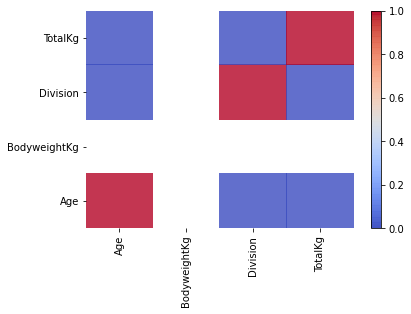

In [ ]:
import matplotlib as mpl

def visualize_correlation_matrix(data, hurdle = 0.0):
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor=False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor=False)
    heatmap.axes.set_xticklabels(data.columns, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(data.columns, minor=False)
    plt.tick_params(which='True', bottom='True', top='False', left = 'False', right = 'False')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(df.loc[:,['Age','BodyweightKg','Division','TotalKg']], hurdle=0.5)

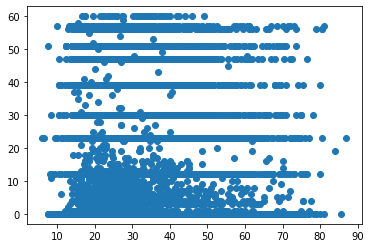

In [ ]:
#figs, axes = plt.subplots(2,3,figsize=(15,7))
#dataset[['RM','target']].plot.scatter(x='RM',y='target',ax=axes[0,0])
#dataset[['PTRATIO','target']].plot.scatter(x='PTRATIO',y='target',ax=axes[0,1])
#dataset[['LSTAT','target']].plot.scatter(x='LSTAT',y='target',ax=axes[0,2])
#dataset[['CRIM','target']].plot.scatter(x='CRIM',y='target',ax=axes[1,0])
#dataset[['AGE','target']].plot.scatter(x='AGE',y='target',ax=axes[1,1])
#dataset[['TAX','target']].plot.scatter(x='TAX',y='target',ax=axes[1,2])


plt.scatter(x=df['Age'],y=df['Place'])


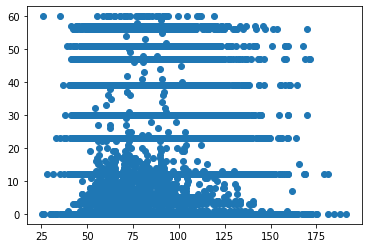

In [ ]:
plt.scatter(x=df['BodyweightKg'],y=df['Place'])

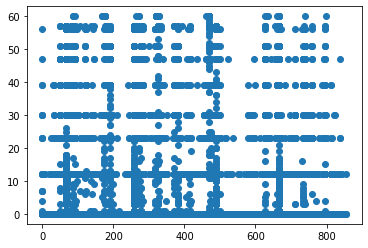

In [ ]:
plt.scatter(x=df['Division'],y=df['Place'])

# Conjuntos de treinamento, validação e teste

Ao trabalhar com modelos de *machine learning*, é imprescindível que seja feita a divisão dos dados entre dados de treinamento, dados de validação e dados de teste (*training set*, *validation set* e *test set*). Essa divisão tem como objetivo avaliar como o modelo está *generalizando* os dados a serem previstos e se não há *overfitting*.

Aqui, vamos dividir o dataset com base no ano de cada registro. Os registros computados até a metade de 2018 formarão o conjunto de treinamento, os registros da metade de 2018 ao final de 2018 serão usados no conjunto de validação, e os restantes compreenderão o conjunto de teste. 

In [ ]:
# Dados
#from sklearn.model_selection import train_test_split
#import seaborn as sns
#iris = sns.load_dataset('iris')
#X_iris = iris.drop('species', axis=1)  # acho que x_iris sao os dados que serao utilizados na previsao
#y_iris = iris['species']               # e y_iris eh o que vamos prever

#Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, random_state=1)

In [37]:
df['AgeClass'] = df['AgeClass'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')

In [38]:
df['AgeClass'] = df['AgeClass'].cat.codes
df['Division'] = df['Division'].cat.codes
df['WeightClassKg'] = df['WeightClassKg'].cat.codes

In [39]:
#x_df = df.drop('Place', axis=1)
#y_df = df['Place']

# Agora vamos dividir em training e test sets

mask_train = (df['Date']<'2018-07-01')
mask_test = (df['Date']>='2018-07-01')

#mask3 = (y_df['Date']<'2018-07-01')
#mask4 = (y_df['Date']>='2018-07-01')

# Os conjuntos 'x' nao contem a coluna sobre a qual sera realizada a previsao
#x_train = df.loc[mask_train].drop('Place', axis=1)
#x_test = df.loc[mask_test].drop('Place', axis=1)

# Sao escolhidas apenas as colunas a partir das quais sera feita a previsao
x_train = df.loc[mask_train, ['Sex','Age','AgeClass','Division','WeightClassKg','BodyweightKg']]
x_test = df.loc[mask_test, ['Sex','Age','AgeClass','Division','WeightClassKg','BodyweightKg']]

# Os conjuntos 'y' contem apenas a coluna a ser prevista
y_train = df.loc[mask_train, 'Place']
y_test = df.loc[mask_test, 'Place']

In [40]:
x_train.head() 

,Sex,Age,AgeClass,Division,WeightClassKg,BodyweightKg
0,1,25.500000,5,490,84,81.20
2,0,46.500000,8,627,57,62.76
3,1,34.410717,0,283,3,101.50
4,1,28.671584,0,327,16,107.20
5,1,45.500000,8,418,21,133.54


In [41]:
y_train.head()

0    3
2    4
3    1
4    2
5    1
Name: Place, dtype: object

In [42]:
len(x_train), len(y_train), len(x_test), len(y_test)

(13469, 13469, 3386, 3386)

# Algoritmos a serem utilizados (*Algoritmos*)

Aqui, empeçaremos a previsão da coluna `Place`. Vamos aplicar simplesmente alguns algoritmos de classificação aos conjuntos de treinamento e teste e avaliar a performance de cada um dos modelos treinados.

## Naive Bayes

In [43]:
x_train.dtypes

Sex                int64
Age              float64
AgeClass            int8
Division           int16
WeightClassKg       int8
BodyweightKg     float64
dtype: object

In [ ]:
#from sklearn.naive_bayes import GaussianNB # 1. escolha da técnica
#model = GaussianNB()                       # 2. instanciação do modelo
#model.fit(Xtrain, ytrain)                  # 3. criação do modelo
#y_model = model.predict(Xtest)             # 4. predição em novos dados

In [ ]:
#from sklearn.metrics import accuracy_score
#accuracy_score(ytest, y_model)

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

modelo1 = GaussianNB()
modelo1.fit(x_train,y_train)
y_modelo1 = modelo1.predict(x_test)

accuracy_score(y_test,y_modelo1)

0.4054932073242764

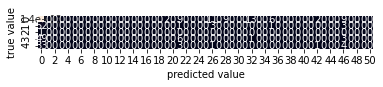

In [50]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_modelo1)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

## Algoritmo 2

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [ ]:
model.fit(X, y)
y_model = model.predict(X)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

In [ ]:
# criação do holdout: divide em treinamento e teste
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# criação do modelo sobre o conjunto de treinamento
model.fit(X1, y1)

# avaliação do modelo no conjunto de teste
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

## Algoritmo 3

## Algoritmo 4